# Minuit 2 Fit Bench
Demonstrate performance and usage of Minuit2 and Fumili2 for monodimensional fits.




**Author:** Lorenzo Moneta  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Thursday, August 29, 2019 at 01:32 AM.</small></i>

In [1]:
%%cpp -d
#include "TH1.h"
#include "TF1.h"
#include "TCanvas.h"
#include "TStopwatch.h"
#include "TSystem.h"
#include "TRandom3.h"
#include "Math/MinimizerOptions.h"
#include "TPaveLabel.h"
#include "TStyle.h"
#include "TMath.h"
#include "TROOT.h"
#include "TFrame.h"
/*#include "Fit/FitConfig.h"*/


TF1 *fitFcn;
TH1 *histo;

  Quadratic background function
 

In [2]:
%%cpp -d
Double_t background(Double_t *x, Double_t *par) {
   return par[0] + par[1]*x[0] + par[2]*x[0]*x[0];
}

  Lorenzian Peak function
 

In [3]:
%%cpp -d
Double_t lorentzianPeak(Double_t *x, Double_t *par) {
   return (0.5*par[0]*par[1]/TMath::Pi()) /
   TMath::Max( 1.e-10,(x[0]-par[2])*(x[0]-par[2]) + .25*par[1]*par[1]);
}

  Sum of background and peak function
 

In [4]:
%%cpp -d
Double_t fitFunction(Double_t *x, Double_t *par) {
  return background(x,par) + lorentzianPeak(x,&par[3]);
}

 A helper function is created: 

In [5]:
%%cpp -d
bool DoFit(const char* fitter, TVirtualPad *pad, Int_t npass) {
   printf("\n*********************************************************************************\n");
   printf("\t %s \n",fitter);
   printf("*********************************************************************************\n");

   gRandom = new TRandom3();
   TStopwatch timer;
   //   timer.Start();
   ROOT::Math::MinimizerOptions::SetDefaultMinimizer(fitter);
   pad->SetGrid();
   pad->SetLogy();
   fitFcn->SetParameters(1,1,1,6,.03,1);
   fitFcn->Update();
   std::string title = std::string(fitter) + " fit bench";
   histo = new TH1D(fitter,title.c_str(),200,0,3);

   TString fitterType(fitter);

   timer.Start();
   bool ok = true;
   // fill histogram many times
   // every time increase its statistics and re-use previous fitted
   // parameter values as starting point
   for (Int_t pass=0;pass<npass;pass++) {
      if (pass%100 == 0) printf("pass : %d\n",pass);
      else printf(".");
      if (pass == 0)fitFcn->SetParameters(1,1,1,6,.03,1);
      for (Int_t i=0;i<5000;i++) {
         histo->Fill(fitFcn->GetRandom());
      }
      int iret = histo->Fit(fitFcn,"Q0");
      ok &= (iret == 0);
      if (iret!=0) Error("DoFit","Fit pass %d failed !",pass);
   }
   // do last fit computing Minos Errors (except for Fumili)
   if (!fitterType.Contains("Fumili"))  // Fumili does not implement Error options (MINOS)
      histo->Fit(fitFcn,"E");
   else
      histo->Fit(fitFcn,"");
   timer.Stop();

   (histo->GetFunction("fitFcn"))->SetLineColor(kRed+3);
   gPad->SetFillColor(kYellow-10);


   Double_t cputime = timer.CpuTime();
   printf("%s, npass=%d  : RT=%7.3f s, Cpu=%7.3f s\n",fitter,npass,timer.RealTime(),cputime);
   TPaveLabel *p = new TPaveLabel(0.45,0.7,0.88,0.8,Form("%s CPU= %g s",fitter,cputime),"brNDC");
   p->Draw();
   p->SetTextColor(kRed+3);
   p->SetFillColor(kYellow-8);
   pad->Update();
   return ok;
}

 Arguments are defined. 

In [6]:
Int_t npass=20;

In [7]:
TH1::AddDirectory(kFALSE);
TCanvas *c1 = new TCanvas("FitBench","Fitting Demo",10,10,900,900);
c1->Divide(2,2);
c1->SetFillColor(kYellow-9);

Create a tf1 with the range from 0 to 3 and 6 parameters

In [8]:
fitFcn = new TF1("fitFcn",fitFunction,0,3,6);
fitFcn->SetNpx(200);
gStyle->SetOptFit();
gStyle->SetStatY(0.6);

bool ok = true;

With minuit

In [9]:
c1->cd(1);
ok &= DoFit("Minuit",gPad,npass);


*********************************************************************************
	 Minuit 
*********************************************************************************
pass : 0
................... FCN=205.276 FROM MINOS     STATUS=SUCCESSFUL     44 CALLS         429 TOTAL
                     EDM=3.83288e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           5.13639e+01   2.01329e+00  -2.79418e-04  -2.05471e-06
   2  p1           5.57813e+01   4.80582e+00   3.09127e-03  -9.98919e-07
   3  p2           7.42112e+01   1.87041e+00  -1.20311e-03  -1.93173e-07
   4  p3           4.27344e+02   2.93232e+00  -1.66243e-02  -7.80957e-07
   5  p4           3.58604e-02   3.47005e-04   1.74159e-07   9.80777e-02
   6  p5           1.00001e+00   1.64203e-04   1.64203e-04   3.19213e-02
Minuit, npass=20  : RT=  0.111 s, Cpu=  0.110 s


With fumili

In [10]:
c1->cd(2);
ok &= DoFit("Fumili",gPad,npass);


*********************************************************************************
	 Fumili 
*********************************************************************************
pass : 0
...................
****************************************
Minimizer is Fumili
Chi2                      =      206.284
NDf                       =          194
NCalls                    =            4
p0                        =      51.4325   +/-   2.01397     
p1                        =      55.5412   +/-   4.81253     
p2                        =      74.2976   +/-   1.87298     
p3                        =      427.425   +/-   2.93868     
p4                        =    0.0358559   +/-   0.000357243 
p5                        =      1.00001   +/-   0.00016009  
Fumili, npass=20  : RT=  0.167 s, Cpu=  0.090 s


With minuit2

In [11]:
c1->cd(3);
ok &= DoFit("Minuit2",gPad,npass);


*********************************************************************************
	 Minuit2 
*********************************************************************************
pass : 0
...................
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =       205.34
NDf                       =          194
Edm                       =  1.91395e-10
NCalls                    =           85
p0                        =      51.3576   +/-   2.0133      
p1                        =      55.8172   +/-   4.80582     
p2                        =      74.1981   +/-   1.8704      
p3                        =      427.317   +/-   2.93218     
p4                        =    0.0358574   +/-   0.000346961 
p5                        =      1.00001   +/-   0.000164204 
Minuit2, npass=20  : RT=  0.072 s, Cpu=  0.070 s


With fumili2

In [12]:
c1->cd(4);
ok &= DoFit("Fumili2",gPad,npass);

c1->SaveAs("FitBench.root");
return (ok) ? 0 : 1;


*********************************************************************************
	 Fumili2 
*********************************************************************************
pass : 0
...................
****************************************
Minimizer is Minuit2 / Fumili
Chi2                      =      207.495
NDf                       =          194
Edm                       =  4.34894e-10
NCalls                    =           92
p0                        =      51.4278   +/-   2.01381     
p1                        =      55.5389   +/-   4.8062      
p2                        =      74.3005   +/-   1.8705      
p3                        =      427.406   +/-   2.93236     
p4                        =    0.0358584   +/-   0.000346902 
p5                        =      1.00001   +/-   0.000164198 
Fumili2, npass=20  : RT=  0.075 s, Cpu=  0.060 s


Info in <TCanvas::SaveAs>: ROOT file FitBench.root has been created


Draw all canvases 

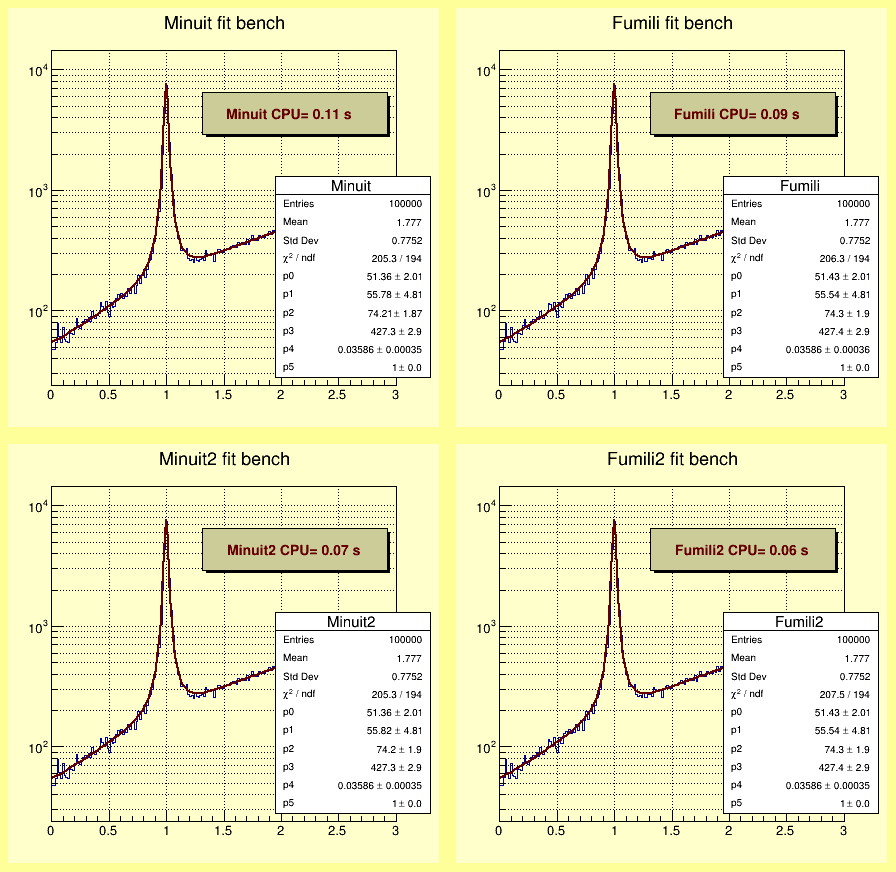

In [13]:
gROOT->GetListOfCanvases()->Draw()